## Giulio Cesare Mastrocinque Santo

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
#Used Libraries
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import time
# magic word for producing visualizations in notebook
sns.set_style("darkgrid")
%matplotlib inline

#Numpy random seed
np.random.seed(11)
#pd.options.display.max_rows = None
#pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

### Gathering

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

#### Explanatory Data Analyses

In [3]:
azdias.head(2)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0


In [4]:
azdias.tail(2)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [5]:
feat_info.sample(10)

,attribute,information_level,type,missing_or_unknown
72,ONLINE_AFFINITAET,region_rr1,ordinal,[]
42,ZABEOTYP,person,categorical,"[-1,9]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"
66,BALLRAUM,postcode,ordinal,[-1]
54,MIN_GEBAEUDEJAHR,building,numeric,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
29,SEMIO_LUST,person,ordinal,"[-1,9]"
51,ANZ_HH_TITEL,building,numeric,[]
39,SOHO_KZ,person,categorical,[-1]
67,EWDICHTE,postcode,ordinal,[-1]


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

**Some Notes:**

TOTAL entries: 891221
- 4 features are from string type
- 81 features are numerical
- 53 of 85 features contains missing values

**Attributes with missing data:**

In [7]:
azdias.columns[azdias.isnull().any()]

Index(['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SOHO_KZ',
       'TITEL_KZ', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP',
       'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3',
       'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_AB'],
      dtype='object')

In [8]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [9]:
azdias.max()

AGER_TYP                    3.0
ALTERSKATEGORIE_GROB        9.0
ANREDE_KZ                   2.0
CJT_GESAMTTYP               6.0
FINANZ_MINIMALIST           5.0
FINANZ_SPARER               5.0
FINANZ_VORSORGER            5.0
FINANZ_ANLEGER              5.0
FINANZ_UNAUFFAELLIGER       5.0
FINANZ_HAUSBAUER            5.0
FINANZTYP                   6.0
GEBURTSJAHR              2017.0
GFK_URLAUBERTYP            12.0
GREEN_AVANTGARDE            1.0
HEALTH_TYP                  3.0
LP_LEBENSPHASE_FEIN        40.0
LP_LEBENSPHASE_GROB        12.0
LP_FAMILIE_FEIN            11.0
LP_FAMILIE_GROB             5.0
LP_STATUS_FEIN             10.0
LP_STATUS_GROB              5.0
NATIONALITAET_KZ            3.0
PRAEGENDE_JUGENDJAHRE      15.0
RETOURTYP_BK_S              5.0
SEMIO_SOZ                   7.0
SEMIO_FAM                   7.0
SEMIO_REL                   7.0
SEMIO_MAT                   7.0
SEMIO_VERT                  7.0
SEMIO_LUST                  7.0
                          ...  
ANZ_HH_T

In [10]:
azdias.mean()

AGER_TYP                   -0.358435
ALTERSKATEGORIE_GROB        2.777398
ANREDE_KZ                   1.522098
CJT_GESAMTTYP               3.632838
FINANZ_MINIMALIST           3.074528
FINANZ_SPARER               2.821039
FINANZ_VORSORGER            3.401106
FINANZ_ANLEGER              3.033328
FINANZ_UNAUFFAELLIGER       2.874167
FINANZ_HAUSBAUER            3.075121
FINANZTYP                   3.790586
GEBURTSJAHR              1101.178533
GFK_URLAUBERTYP             7.350304
GREEN_AVANTGARDE            0.196612
HEALTH_TYP                  1.792102
LP_LEBENSPHASE_FEIN        14.622637
LP_LEBENSPHASE_GROB         4.453621
LP_FAMILIE_FEIN             3.599574
LP_FAMILIE_GROB             2.185966
LP_STATUS_FEIN              4.791151
LP_STATUS_GROB              2.432575
NATIONALITAET_KZ            1.026827
PRAEGENDE_JUGENDJAHRE       8.154346
RETOURTYP_BK_S              3.419630
SEMIO_SOZ                   3.945860
SEMIO_FAM                   4.272729
SEMIO_REL                   4.240609
S

In [11]:
#The information bellow will be used latter in the project
number_of_actual_nan = azdias.isna().sum()
print(f"Number of NaN Values for the Training Data {number_of_actual_nan.sum()}")

Number of NaN Values for the Training Data 4896838


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.

#Making a copy of the feat_info data
feat_info_clean = feat_info.copy()

**First, lets convert the string values of the "missing_or_unkwnown" column into actual lists:**

In [13]:
codes = list(feat_info_clean['missing_or_unknown'].values)
list_of_codes = []
for code in codes:
    try:
        list_of_codes.append(list(map(int,code.replace(']','').replace('[','').split(','))))
    except:
        list_of_codes.append(code.replace(']','').replace('[','').split(','))

In [14]:
feat_info_clean['missing_or_unknown'] = list_of_codes

In [15]:
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


**Now, lets replace this values by numpy.nan in the demographics data. Also, lets count how many nan values were included in order to compare this number with the number of actual nan values in the dataset. Bellow I am suggesting an optimized manner of doing such a replacement.**

In [16]:
missing_or_unknown = feat_info_clean['missing_or_unknown'].values
attribute = feat_info_clean['attribute'].values

start = time. time()
for column in azdias.columns:
    for value in missing_or_unknown[np.argwhere(attribute==column)].tolist()[0][0]:
        try:
            azdias[column] = np.where(azdias[column]==value,np.nan,azdias[column])
        except:
            pass
end = time. time()
print(f"Execution finished in {end-start} seconds")

/opt/conda/lib/python3.6/site-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Execution finished in 5.688472747802734 seconds


In [17]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
final_number_of_nan = azdias.isna().sum()
display(final_number_of_nan)
display(number_of_actual_nan)
print(f"Number of NaNs in the adjusted dataset: {final_number_of_nan.sum()}")
print(f"Number of NaNs in the original dataset: {number_of_actual_nan.sum()}")
print(f"Number of included NaNs {final_number_of_nan.sum() - number_of_actual_nan.sum()}")

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

Number of NaNs in the adjusted dataset: 8373929
Number of NaNs in the original dataset: 4896838
Number of included NaNs 3477091


In [19]:
final_number_of_nan.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

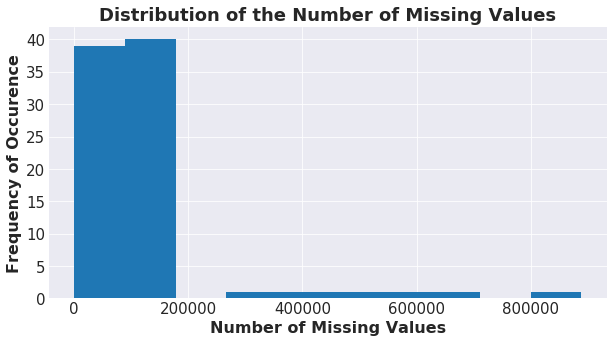

In [20]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10,5));
plt.hist(final_number_of_nan);
plt.title("Distribution of the Number of Missing Values",fontsize=18,weight='bold');
plt.ylabel("Frequency of Occurence",fontsize=16,weight='bold');
plt.xlabel("Number of Missing Values",fontsize=16,weight='bold');
plt.tick_params(axis='both', which='major', labelsize=15);

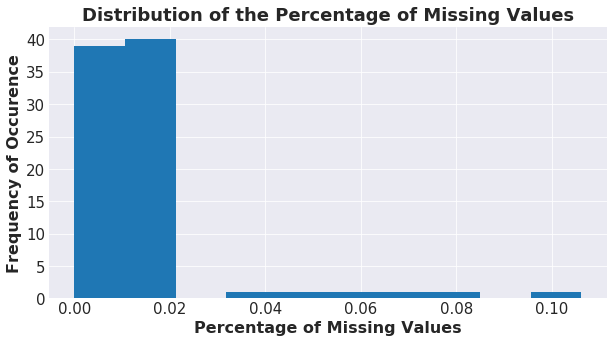

In [21]:
plt.figure(figsize=(10,5));
plt.hist(final_number_of_nan/final_number_of_nan.sum());
plt.title("Distribution of the Percentage of Missing Values",fontsize=18,weight='bold');
plt.ylabel("Frequency of Occurence",fontsize=16,weight='bold');
plt.xlabel("Percentage of Missing Values",fontsize=16,weight='bold');
plt.tick_params(axis='both', which='major', labelsize=15);

**From both figures above, one can clearly notice that the majority of the data is concentrated around features with basically none missing values (0% and 0.02%). The outliers are also highlighted, being represented by features that have between 4% and 10% of missing values. Those outliers must be removed.**

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print(final_number_of_nan[final_number_of_nan > 200000])
outlier_columns = list(final_number_of_nan[final_number_of_nan > 200000].index)

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64


In [23]:
azdias.drop(outlier_columns, axis=1, inplace=True)

In [24]:
azdias.head(1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Notice that the number of columns dropped to 79!**

#### Lets investigate for patterns in the missing data

In [25]:
final_number_of_nan.value_counts().sort_values(ascending=False)

0         24
116515     7
4854       6
133324     6
93148      4
73499      4
111196     3
99352      3
93740      3
97375      2
77792      2
158064     2
108164     1
93155      1
584612     1
392318     1
889061     1
147988     1
99611      1
97274      1
108315     1
73969      1
18348      1
97632      1
476524     1
2881       1
105800     1
97008      1
310267     1
94572      1
685843     1
dtype: int64

**We can see that we have some number of missing values that occur more than once. Lets check which features are associated with those values:**

In [26]:
pattern_1 = list(final_number_of_nan.index[np.squeeze(np.argwhere(final_number_of_nan==116515))])
print(pattern_1)
print(azdias[pattern_1].head(5))

['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']
   PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  \
0         NaN         NaN         NaN         NaN          NaN       NaN   
1         2.0         3.0         2.0         1.0          1.0       5.0   
2         3.0         3.0         1.0         0.0          1.0       4.0   
3         2.0         2.0         2.0         0.0          1.0       3.0   
4         2.0         4.0         2.0         1.0          2.0       3.0   

   PLZ8_GBZ  
0       NaN  
1       4.0  
2       4.0  
3       4.0  
4       3.0  


In [27]:
pattern_2 = list(final_number_of_nan.index[np.squeeze(np.argwhere(final_number_of_nan==4854))])
print(pattern_2)
print(azdias[pattern_2].head(5))

['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET']
   CJT_GESAMTTYP  GFK_URLAUBERTYP  LP_STATUS_FEIN  LP_STATUS_GROB  \
0            2.0             10.0             1.0             1.0   
1            5.0             10.0             2.0             1.0   
2            3.0             10.0             3.0             2.0   
3            2.0              1.0             9.0             4.0   
4            5.0              5.0             3.0             2.0   

   RETOURTYP_BK_S  ONLINE_AFFINITAET  
0             5.0                1.0  
1             1.0                3.0  
2             3.0                2.0  
3             2.0                1.0  
4             5.0                5.0  


In [28]:
pattern_3 = list(final_number_of_nan.index[np.squeeze(np.argwhere(final_number_of_nan==133324))])
print(pattern_3)
print(azdias[pattern_3].head(5))

['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO']
   KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  MOBI_REGIO
0          NaN          NaN          NaN          NaN        NaN         NaN
1          0.0          0.0          0.0          2.0        1.0         1.0
2          1.0          3.0          1.0          0.0        3.0         3.0
3          4.0          1.0          0.0          0.0        4.0         4.0
4          1.0          4.0          1.0          0.0        3.0         3.0


In [29]:
pattern_4 = list(final_number_of_nan.index[np.squeeze(np.argwhere(final_number_of_nan==93148))])
print(pattern_4)
print(azdias[pattern_4].head(5))

['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE']
   GEBAEUDETYP  MIN_GEBAEUDEJAHR OST_WEST_KZ  WOHNLAGE
0          NaN               NaN         NaN       NaN
1          8.0            1992.0           W       4.0
2          1.0            1992.0           W       2.0
3          1.0            1997.0           W       7.0
4          1.0            1992.0           W       3.0


In [30]:
pattern_5 = list(final_number_of_nan.index[np.squeeze(np.argwhere(final_number_of_nan==73499))])
print(pattern_5)
print(azdias[pattern_5].head(5))

['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008']
   SOHO_KZ  ANZ_PERSONEN  ANZ_TITEL  WOHNDAUER_2008
0      NaN           NaN        NaN             NaN
1      1.0           2.0        0.0             9.0
2      0.0           1.0        0.0             9.0
3      0.0           0.0        0.0             9.0
4      0.0           4.0        0.0             9.0


In [31]:
pattern_6 = list(final_number_of_nan.index[np.squeeze(np.argwhere(final_number_of_nan==111196))])
print(pattern_6)
print(azdias[pattern_6].head(5))

['HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']
   HEALTH_TYP  SHOPPER_TYP  VERS_TYP
0         NaN          NaN       NaN
1         3.0          3.0       2.0
2         3.0          2.0       1.0
3         2.0          1.0       1.0
4         3.0          2.0       2.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

We started up running an optimized routine to map the missing and unknown values described in the info_clean dictionary to the azdias demographic dataset. At this point, we conclude the following:

- The original azdias dataset has 4896838 NaN values
- The mapping procedure allowed us to find additional 3477091 missing or unkwnon values
- We end up if a final dataset that contains 8373929, which is kind of a lot!

Going deeper in the investigation of the NaN values, we concluded that most of the NaN values were concentrated around 0 and 0.02% of the total number of missing value, which means that most of the features actually do not have that much NaN values! Outliers were features with more than 200000 missing values and those features were removed. The index of those features are the following:

Deleted features and their number of missing values are listed bellow: 

- AGER_TYP        (685843 missing values)

- GEBURTSJAHR     (392318 missing values)

- TITEL_KZ        (889061 missing values)

- ALTER_HH        (310267 missing values)

- KK_KUNDENTYP    (584612 missing values)

- KBA05_BAUMAX    (476524 missing values)

For the remaining features, we also noticed through a frequency table that some features apperently follow a pattern since they present the exact same number of missing values. Some of these groups are listed bellow:

**Group 1: all of the features in this group contains 116515 missing values**

['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']

**Group 2: all of the features in this group contains 4854 missing values**

['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET']

**Group 3: all of the features in this group contains 133324 missing values**

['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO']

**Group 4: all of the features in this group contains 73499 missing values**

['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE']

**Group 5: all of the features in this group contains 111196 missing values**

['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008']

**Group 6: all of the features in this group contains 99352 missing values**

['HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']

Moreover, as we saw, although the features in each group do not display the **exact same** information, they indeed do respect to very similar subjects. Further analysis may probably indicate that some of these features can be disregarded.

It is also interest to point out that features that **do not have missing values** ar eon the person level of recording!

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [32]:
# How much data is missing in each row of the dataset?
rows_nan = azdias.isnull().sum(axis=1)
print(rows_nan.sort_values(ascending=False))

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64


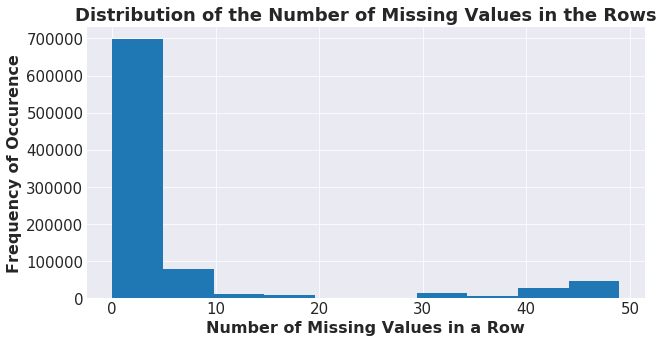

In [33]:
plt.figure(figsize=(10,5));
plt.hist(rows_nan);
plt.title("Distribution of the Number of Missing Values in the Rows",fontsize=18,weight='bold');
plt.ylabel("Frequency of Occurence",fontsize=16,weight='bold');
plt.xlabel("Number of Missing Values in a Row",fontsize=16,weight='bold');
plt.tick_params(axis='both', which='major', labelsize=15);

**From the figure above, one can clearly see two distributions: one in which the rows contain less than 20 missing values along its columns, and another one in which the rows contain more than 20 missing values along its columns. In order to catch both groups precisely, we can use 25 as the division value.**

In [34]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_dist_1 = azdias[azdias.isnull().sum(axis=1) < 25]
azdias_dist_2 = azdias[azdias.isnull().sum(axis=1) > 25]

In [35]:
print(f"Shape of distribution 1 (fewer number missing values): {azdias_dist_1.shape}")
print(f"Shape of distribution 2 (higher number missing values): {azdias_dist_2.shape}")

Shape of distribution 1 (fewer number missing values): (797906, 79)
Shape of distribution 2 (higher number missing values): (93260, 79)


In [36]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#Lets take 5 random columns that do not have missing values
azdias[azdias.columns[azdias.isna().sum() == 0]].head(5)

,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GREEN_AVANTGARDE,SEMIO_SOZ,...,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ZABEOTYP
0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,0,2.0,...,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,3.0
1,2.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,0,5.0,...,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,5.0
2,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,1,4.0,...,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,5.0
3,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,0,5.0,...,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,3.0
4,1.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,0,6.0,...,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,4.0


**Lets choose 5 random columns where there are no missing values**

In [37]:
np.random.seed(11)
radn_columns = np.random.choice(azdias.columns[azdias.isna().sum() == 0],5,replace=False)

In [38]:
radn_columns

array(['SEMIO_FAM', 'SEMIO_KRIT', 'FINANZ_HAUSBAUER', 'SEMIO_LUST',
       'FINANZ_VORSORGER'], dtype=object)

In [39]:
print("Chosen columns:")
print(list(radn_columns))

Chosen columns:
['SEMIO_FAM', 'SEMIO_KRIT', 'FINANZ_HAUSBAUER', 'SEMIO_LUST', 'FINANZ_VORSORGER']


In [40]:
def plot_columns_distributions(list_of_df, column):
    """
    This function take both distribution dataframes as a list and
    plot the given column distribution for each dataframe.
    
    Arguments:
        list_of_df: a list with both dataframes ([azdias_dist_1, azdias_dist_2])
        column: the desired column
    """
    plt.figure(figsize=(15,4))
    
    #Plot for dataframe with fewer number of NaNs in the rows
    plt.subplot(1,2,1)
    sns.countplot(x=column, data=list_of_df[0])
    plt.title(f"Dist. of feature {column} \n Df. With Fewer NaNs",fontsize=18,weight='bold');
    plt.ylabel("Frequency of Occurence",fontsize=16,weight='bold');
    plt.xlabel(f"Values of feature {column}",fontsize=16,weight='bold');
    plt.tick_params(axis='both', which='major', labelsize=15);
    
    #Plot for dataframe with higher number of NaNs in the rows
    plt.subplot(1,2,2)
    sns.countplot(x=column, data=list_of_df[1])
    plt.title(f"Dist. of feature {column} \n Df. With Higher NaNs",fontsize=18,weight='bold');
    plt.ylabel(f"Frequency of Occurence",fontsize=16,weight='bold');
    plt.xlabel(f"Values of feature {column}",fontsize=16,weight='bold');
    plt.tick_params(axis='both', which='major', labelsize=15);
    
    plt.subplots_adjust(hspace = .8, wspace=1.2)
    plt.show()

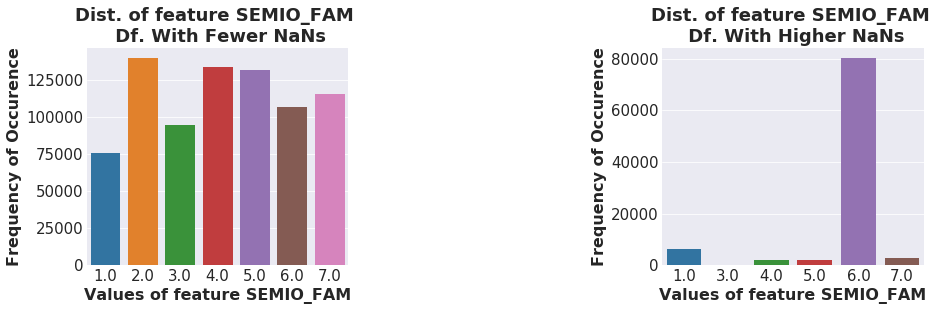

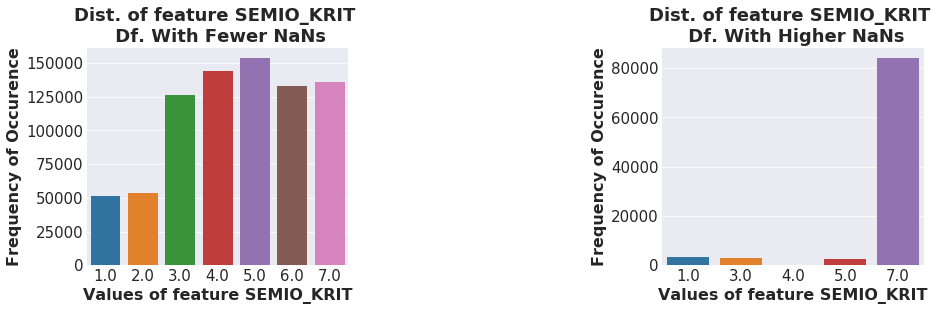

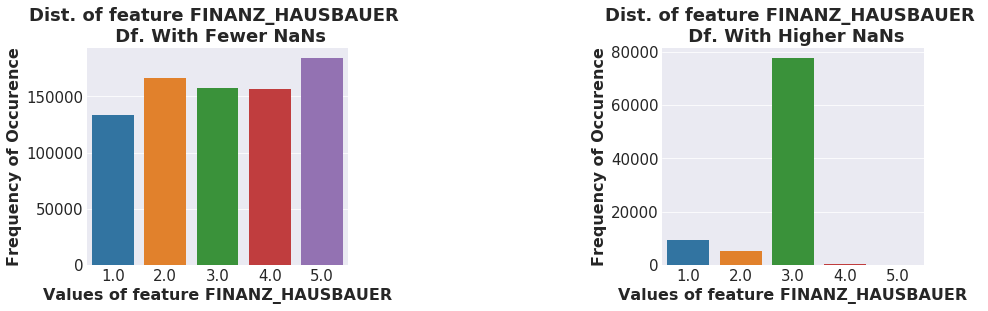

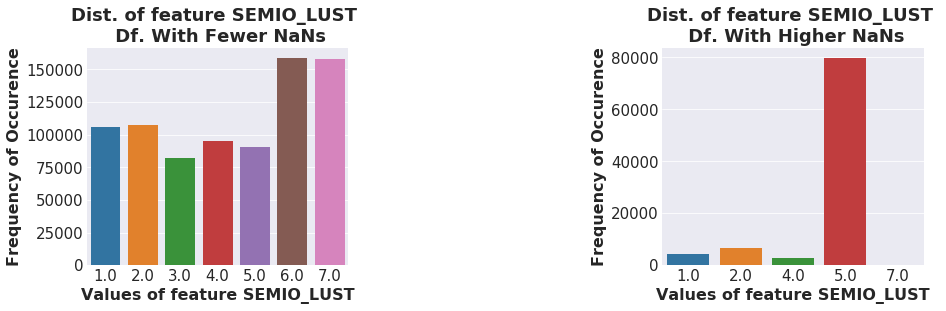

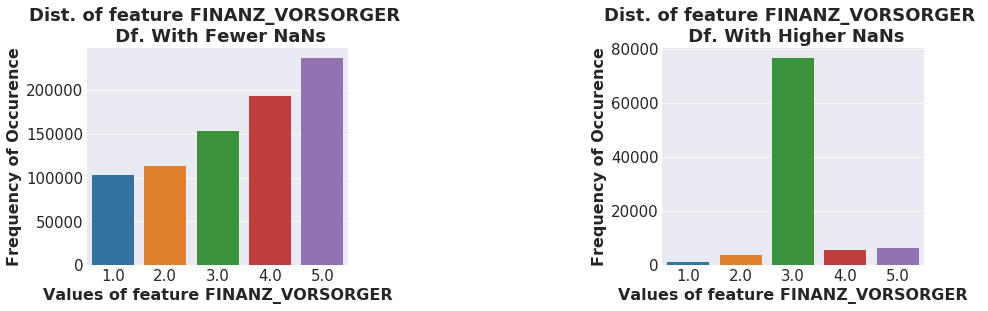

In [41]:
list_of_df = [azdias_dist_1,azdias_dist_2]

for column in radn_columns:
    plot_columns_distributions(list_of_df,column)

We can also perform a Hypothesis Test in order to compare if both sets (the one bellow 20 and the one above it) have the same probability distribution.

The test can be formulated as follows:

$$H_{0}: Samples \,\,\, are \,\,\, drawn \,\,\, from \,\,\, the \,\,\, same \,\,\, distribution$$
$$H_{1}: Samples \,\,\, are \,\,\, drawn \,\,\, from \,\,\, different \,\,\, distributions$$

One way to perform this test is using the nonparametric **Kolmogorov–Smirnov** test.

The function bellow was provided by Udacity's reviwer:

In [42]:
def hypothesis_test(df1, df2, cols):
    """
    This function makes a nonparametric Kolmogorov-Smirnov Hypothesis Test
    in order to compare df1 and df2 distributions.
    
    Arguments:
        df1: first dataframe with a certain ditribution
        df2: second dataframe with a certain ditribution
        cols: main dataframe column
    """
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

In [43]:
comp_df = pd.DataFrame(azdias.columns, columns=['col'])
stats, pvalues = hypothesis_test(azdias_dist_1, azdias_dist_2, azdias_dist_1.columns.values)
comp_df['stats'] = stats
comp_df['pvalues'] = pvalues
comp_df.head()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:4751: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(data2, data_all, side='right') / (1.0*n2)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:4756: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


,col,stats,pvalues
0,ALTERSKATEGORIE_GROB,1.0,0.011066
1,ANREDE_KZ,1.0,0.097027
2,CJT_GESAMTTYP,1.0,0.001300
3,FINANZ_MINIMALIST,1.0,0.003781
4,FINANZ_SPARER,1.0,0.003781


In [44]:
comp_df['pvalues'].mean()

0.054941898841356432

We can see that, in average, we have a p-value of 0.055, which mean we can reject the null hypithesis with a probability of 5,5% of making a mistake! In order words, one could say that the distributions are different with 0.055 statistical significance.

#### Discussion 1.1.3: Assess Missing Data in Each Row

If we look at rows with missing values (i.e, rows with missing attributes), we can clearly identify two different groups:

- The first group contains rows with less than 20 missing attributes.
- The second group contains rows with more than 20 missing attributes.

To understand the impact of the rows with high number of missing attributes (second group), I selected 5 random features that do not have missing values and analysed how the values for theses features are distributed in both groups.

Results show that the distribution for the second group is a little bit distorted: some attributes values are out of these group, but some features remained in high quantity. The problem here is that, when removing these second group of the data, we could be losing some informations of important features, i.e, features that **do not have missing values**. This conclusion is also supported by the Kolmogorov–Smirnov hypothesis test, which confirmed that the distributions are different with a 0.055 level of significance.

Lets take the distribution of feature FINAZ_VORSORGER as an example. We can see that the second group follows the same value distribution as the group one, except for two aspects:

   - 1) the second group has a smaller frequency of occurence (i.e, only the ditribution **shape** is the same). This is a good and expected characteristic.
   - 2) the value "3.0" of this attribute is distorted and appears in the second group with a too high frequency. That could be a problem if we decide to delete the second group from the dataset, because we would be loosing a fair amount of information for the value "3.0" of the feature FINAZ_VORSORGER.
   
On the contrary, since this behaviour seems to occur only for isolated values of some features, and not for the majority, we can move on disregarding the second group. We would be required to consider the second group if a considerable amount of features were present in the second group with a high amount of distorted values and with different shapes (which is not the case). Moreover, the number of points in the second group is much smaller compared to the first one.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [45]:
# How many features are there of each data type?
print("Number of features per data type:")
feat_info['type'].value_counts()

Number of features per data type:


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Lets verify how many of these feature types are in the azdias_dist_1 dataset, which is the one with low number of NaN in the rows!

In [46]:
feat_info = feat_info[feat_info['attribute'].isin(azdias_dist_1.columns)]

In [47]:
# How many features are there of each data type? -> Answer for the cleaned dataset
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [48]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = list(feat_info[feat_info['type']=='categorical']['attribute'].values)
azdias_dist_1[categorical_features].head(1)

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2.0,5.0,1.0,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,W,8,8A


In [49]:
for column in azdias_dist_1[categorical_features].columns:
    print(f"Unique values of feature {column}")
    print(azdias_dist_1[column].unique())

Unique values of feature ANREDE_KZ
[ 2.  1.]
Unique values of feature CJT_GESAMTTYP
[  5.   3.   2.   4.   1.   6.  nan]
Unique values of feature FINANZTYP
[ 1.  6.  5.  2.  4.  3.]
Unique values of feature GFK_URLAUBERTYP
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
Unique values of feature GREEN_AVANTGARDE
[0 1]
Unique values of feature LP_FAMILIE_FEIN
[  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
Unique values of feature LP_FAMILIE_GROB
[  3.   1.  nan   5.   2.   4.]
Unique values of feature LP_STATUS_FEIN
[  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
Unique values of feature LP_STATUS_GROB
[  1.   2.   4.   5.   3.  nan]
Unique values of feature NATIONALITAET_KZ
[  1.   3.   2.  nan]
Unique values of feature SHOPPER_TYP
[  3.   2.   1.   0.  nan]
Unique values of feature SOHO_KZ
[ 1.  0.]
Unique values of feature VERS_TYP
[  2.   1.  nan]
Unique values of feature ZABEOTYP
[ 5.  3.  4.  1.  6.  2.]
Unique values of feature GEBAEUDETY

#### Notice: I will not be considering any multi-level categorical feature. The reason I am doing this is because we will be using unsupervised learning methods that do not work well with categorical and mixed data. Some very good articles about the implications of using categorical data with Euclidian distance unsupervised learning algorithms can be found in the following references:

https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data

https://towardsdatascience.com/clustering-on-mixed-type-data-8bbd0a2569c3

https://www.quora.com/Why-does-K-means-clustering-perform-poorly-on-categorical-data-The-weakness-of-the-K-means-method-is-that-it-is-applicable-only-when-the-mean-is-defined-one-needs-to-specify-K-in-advance-and-it-is-unable-to-handle-noisy-data-and-outliers

In [50]:
# Re-encode categorical variable(s) to be kept in the analysis.
#Treating binary features
azdias_dist_1['ANREDE_KZ'] = np.where(azdias_dist_1['ANREDE_KZ'] == 2, 1, 0)
azdias_dist_1['SOHO_KZ'] = np.where(azdias_dist_1['SOHO_KZ'] == 1.0, 1, 0)
azdias_dist_1['VERS_TYP'] = np.where(azdias_dist_1['VERS_TYP'] == 2, 1, 0)
azdias_dist_1['OST_WEST_KZ'] = np.where(azdias_dist_1['OST_WEST_KZ'] == 'W', 1, 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [51]:
#Treating  multi-level categoricals (I will be dropping them all)
for column in azdias_dist_1[categorical_features].columns:
    if column not in ['ANREDE_KZ','SOHO_KZ','VERS_TYP','OST_WEST_KZ']:
        azdias_dist_1.drop(column,axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [52]:
azdias_dist_1.head(1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,1,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0


In [53]:
print("FInal Shape after treating categorical features:")
print(azdias_dist_1.shape)

FInal Shape after treating categorical features:
(797906, 65)


#### Discussion 1.2.1: Re-Encode Categorical Features
As we can seen from the previous analysis, 18 of 79 features are categorical. From this 18 features, only 5 (ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP and OST_WEST_KZ) are binary. All other 13 are multi-level. That means we have a significantly amount of data represented by multi-level categorical features. Therefore, I decided to used those features instead of drop them. The way I used those features was applying one hot encoding. Therefore, the resulting dataframe has 623209 rows and 178 features.

It is important no notice that not all binary features were already in the (0,1) format. For example, the values for feature OST_WEST_KZ are originally ['W', 'O']. Therefore, those feature were also treated in order to convert them into the values 0 and 1.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

**Some Initial Observations:**

If we take a closer look to the Data_Dictionary.md file, we can se the following description for the PRAEGENDE_JUGENDJAHRE feature:

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

From the description above, one can se a straightforward convertion for the decades:

- 1 <-> 40, 2 <-> 40, 3 <-> 50, 4 <-> 50, and so on so forth.

For the movement variable, one could considered the Mainstream vs Aventgarde information. We could, for example, consider Mainstream = 1 and Aventgarde = 2.

These two new numerical variables fully describe the PRAEGENDE_JUGENDJAHRE feature. For example, if we have the values (40,1) for the new variables, we would know that this equivalent to 40s - war years (Mainstream, E+W).

In the same way, if we take a closer look to the CAMEO_INTL_2015 feature, we ovatain the following:

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

Therefore, we can do the following map:

- For wealthy stage:
    - wealthy households (1)
    - prosperous households (2)
    - comfortable households (3)
    - less affluent households (4)
    - poorer households (5)
    
    
- For  life stage:
    - pre-family couples & singles (1)
    - young couples with children (2)
    - families with school age children (3)
    - older families & mature couples (4)
    - elders in retirement (5)
    
Again, combining these two variables we can fully describe all the 25 values of the CAMEO_INTL_2015 feature.

In [54]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_dist_1['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182964
8.0     141598
10.0     85793
5.0      84682
3.0      53840
15.0     42540
11.0     35746
9.0      33569
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5762
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [55]:
azdias_dist_1['generation_by_decade'] = np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 1,40,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 2,40,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 3,50,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 4,50,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 5,60,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 6,60,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 7,60,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 8,70,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 9,70,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 10,80,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 11,80,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 12,80,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 13,80,
                                                 np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 14,90,90))))))))))))))

azdias_dist_1['generation_by_movement'] = np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 1,1,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 2,0,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 3,1,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 4,0,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 5,1,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 6,0,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 7,0,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 8,1,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 9,0,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 10,1,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 11,0,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 12,1,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 13,0,
                                                   np.where(azdias_dist_1['PRAEGENDE_JUGENDJAHRE'] == 14,1,0))))))))))))))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
azdias_dist_1['generation_by_decade'].value_counts()

90    254201
70    175167
80    151747
60    114343
50     74291
40     28157
Name: generation_by_decade, dtype: int64

In [57]:
azdias_dist_1['generation_by_movement'].value_counts()

1    594001
0    203905
Name: generation_by_movement, dtype: int64

In [58]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_dist_1['CAMEO_INTL_2015'].value_counts()


51    133691
41     92336
24     91147
14     62880
43     56671
54     45390
25     39624
22     33149
23     26732
13     26332
45     26132
55     23954
52     20542
31     19012
34     18524
15     16974
44     14820
12     13245
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [59]:
azdias_dist_1['wealthy_stage'] = np.where(((azdias_dist_1['CAMEO_INTL_2015'] == '11') | 
                                           (azdias_dist_1['CAMEO_INTL_2015'] == '12') |
                                           (azdias_dist_1['CAMEO_INTL_2015'] == '13') |
                                           (azdias_dist_1['CAMEO_INTL_2015'] == '14') |
                                           (azdias_dist_1['CAMEO_INTL_2015'] == '15')),1,
                                           np.where(((azdias_dist_1['CAMEO_INTL_2015'] == '21') | 
                                                     (azdias_dist_1['CAMEO_INTL_2015'] == '22') |
                                                     (azdias_dist_1['CAMEO_INTL_2015'] == '23') |
                                                     (azdias_dist_1['CAMEO_INTL_2015'] == '24') |
                                                     (azdias_dist_1['CAMEO_INTL_2015'] == '25')),2,
                                                     np.where(((azdias_dist_1['CAMEO_INTL_2015'] == '31') | 
                                                               (azdias_dist_1['CAMEO_INTL_2015'] == '32') |
                                                               (azdias_dist_1['CAMEO_INTL_2015'] == '33') |
                                                               (azdias_dist_1['CAMEO_INTL_2015'] == '34') |
                                                               (azdias_dist_1['CAMEO_INTL_2015'] == '35')),3,
                                                               np.where(((azdias_dist_1['CAMEO_INTL_2015'] == '41') | 
                                                                         (azdias_dist_1['CAMEO_INTL_2015'] == '42') |
                                                                         (azdias_dist_1['CAMEO_INTL_2015'] == '43') |
                                                                         (azdias_dist_1['CAMEO_INTL_2015'] == '44') |
                                                                         (azdias_dist_1['CAMEO_INTL_2015'] == '45')),4,5))))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
azdias_dist_1['life_stage'] = np.where(((azdias_dist_1['CAMEO_INTL_2015'] == '11') | 
                                        (azdias_dist_1['CAMEO_INTL_2015'] == '21') |
                                        (azdias_dist_1['CAMEO_INTL_2015'] == '31') |
                                        (azdias_dist_1['CAMEO_INTL_2015'] == '41') |
                                        (azdias_dist_1['CAMEO_INTL_2015'] == '51')),1,
                                        np.where(((azdias_dist_1['CAMEO_INTL_2015'] == '12') | 
                                                  (azdias_dist_1['CAMEO_INTL_2015'] == '22') |
                                                  (azdias_dist_1['CAMEO_INTL_2015'] == '32') |
                                                  (azdias_dist_1['CAMEO_INTL_2015'] == '42') |
                                                  (azdias_dist_1['CAMEO_INTL_2015'] == '52')),2,
                                                  np.where(((azdias_dist_1['CAMEO_INTL_2015'] == '13') | 
                                                            (azdias_dist_1['CAMEO_INTL_2015'] == '23') |
                                                            (azdias_dist_1['CAMEO_INTL_2015'] == '33') |
                                                            (azdias_dist_1['CAMEO_INTL_2015'] == '43') |
                                                            (azdias_dist_1['CAMEO_INTL_2015'] == '53')),3,
                                                            np.where(((azdias_dist_1['CAMEO_INTL_2015'] == '14') | 
                                                                      (azdias_dist_1['CAMEO_INTL_2015'] == '24') |
                                                                      (azdias_dist_1['CAMEO_INTL_2015'] == '34') |
                                                                      (azdias_dist_1['CAMEO_INTL_2015'] == '44') |
                                                                      (azdias_dist_1['CAMEO_INTL_2015'] == '54')),4,5))))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [61]:
azdias_dist_1['wealthy_stage'].value_counts()

5    229683
2    190652
4    189959
1    119431
3     68181
Name: wealthy_stage, dtype: int64

In [62]:
azdias_dist_1['life_stage'].value_counts()

1    245039
4    232761
5    123146
3    119670
2     77290
Name: life_stage, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

As described in the begining of this topic, four new features were created:

- generation_by_decade: it is a sub-feature of PRAEGENDE_JUGENDJAHRE and indicates the corresponding decades
- generation_by_movement: it is also a sub-feature of PRAEGENDE_JUGENDJAHRE and indicates if the person's movement is avantgarde (0) or mainstream (1)
- wealthy_stage: it is a sub-feature of CAMEO_INTL_2015 and indicates the wealthy stages
- life_stage: it is also a sub-feature of CAMEO_INTL_2015 and indicates the life stages

Notice that wealthy_stage and life_stage are ordinal variables and, therefore, will not be transformed in this project.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

#### Lets see what features we endup with:

In [63]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
list(azdias_dist_1.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_AN

In [64]:
print("Mixed Attributes: ")
list(feat_info[feat_info['type']=='mixed']['attribute'].values)

Mixed Attributes: 


['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

#### From above, one can notice that we still have some work to do, as follows:

   - PRAEGENDE_JUGENDJAHRE needs to be deleted
   - CAMEO_INTL_2015 needs to be deleted
   - we still have four mixed features (LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE, PLZ8_BAUMAX) that were not treated. Feature WOHNLAGE will be reengeneered and transformed into a dummy variable.

In [65]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#Delete PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
azdias_dist_1.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [66]:
#Lets also remove the remaining mixed features. Feature WOHNLAGE will be reengeneered
azdias_dist_1.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PLZ8_BAUMAX'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


As a final step, I will be engineering two more features based on the WOHNLAGE one:
   - One feature will be for rural neighborhood  (dummy equals to 1)
   - Another feature will for non rural flag (dummy equals to 0)

The functions bellow were suggested by Udacity's reviewer:

In [67]:
def create_new_WOHNLAGE(row):
    if np.isnan(row): return row
    if row in [1., 2., 3., 4., 5.]: return 1
    elif row in [7., 8.]: return 0
    else: return 0

In [68]:
azdias_dist_1['dummy_WOHNLAGE'] = azdias_dist_1['WOHNLAGE'].apply(create_new_WOHNLAGE)
azdias_dist_1.drop(['WOHNLAGE'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [69]:
print("Final Shape: ")
print(azdias_dist_1.shape)

Final Shape: 
(797906, 64)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [106]:
def clean_data(df,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame and summary of feature attributes
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    
    #Make a copy of the deat_info dataframe
    feat_info_clean = feat_info.copy()
    
    #Transform missing_or_unknows codes into appropriate form (list)
    codes = list(feat_info_clean['missing_or_unknown'].values)
    
    list_of_codes = []
    for code in codes:
        try:
            list_of_codes.append(list(map(int,code.replace(']','').replace('[','').split(','))))
        except: #When value is not a number, but a strin
            list_of_codes.append(code.replace(']','').replace('[','').split(','))
    
    feat_info_clean['missing_or_unknown'] = list_of_codes
    
    #Use the codes to include additional NaN values in the df
    missing_or_unknown = feat_info_clean['missing_or_unknown'].values
    attribute = feat_info_clean['attribute'].values

    for column in df.columns:
        for value in missing_or_unknown[np.argwhere(attribute==column)].tolist()[0][0]:
            try:
                df[column] = np.where(df[column]==value,np.nan,df[column])
            except: #When value is null (nothing to convert)
                pass
            
    
    # remove selected columns and rows, ...
    outlier_columns = ['AGER_TYP', 'GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    df.drop(outlier_columns, axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    # Re-encode categorical variable(s) to be kept in the analysis.
    
    #Treating binary features
    df['ANREDE_KZ'] = np.where(df['ANREDE_KZ'] == 2, 1, 0)
    df['SOHO_KZ'] = np.where(df['SOHO_KZ'] == 1.0, 1, 0)
    df['VERS_TYP'] = np.where(df['VERS_TYP'] == 2, 1, 0)
    df['OST_WEST_KZ'] = np.where(df['OST_WEST_KZ'] == 'W', 1, 0)

    #Treating  multi-level categoricals
    categorical_features = feat_info[feat_info['type']=='categorical']['attribute'].values
    categorical_features = categorical_features[[item in df.columns for item in categorical_features]].tolist()
    
    
    for column in df[categorical_features].columns:
        if column not in ['ANREDE_KZ','SOHO_KZ','VERS_TYP','OST_WEST_KZ']:
            df.drop(column,axis=1,inplace=True)

        
    #Treating Mixed Variables
    df['generation_by_decade'] = np.where(df['PRAEGENDE_JUGENDJAHRE'] == 1,40,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 2,40,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 3,50,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 4,50,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 5,60,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 6,60,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 7,60,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 8,70,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 9,70,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 10,80,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 11,80,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 12,80,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 13,80,
                                                np.where(df['PRAEGENDE_JUGENDJAHRE'] == 14,90,90))))))))))))))

    df['generation_by_movement'] = np.where(df['PRAEGENDE_JUGENDJAHRE'] == 1,1,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 2,0,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 3,1,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 4,0,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 5,1,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 6,0,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 7,0,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 8,1,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 9,0,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 10,1,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 11,0,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 12,1,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 13,0,
                                                  np.where(df['PRAEGENDE_JUGENDJAHRE'] == 14,1,0))))))))))))))
    
    df['wealthy_stage'] = np.where(((df['CAMEO_INTL_2015'] == '11') | 
                                          (df['CAMEO_INTL_2015'] == '12') |
                                          (df['CAMEO_INTL_2015'] == '13') |
                                          (df['CAMEO_INTL_2015'] == '14') |
                                          (df['CAMEO_INTL_2015'] == '15')),1,
                                          np.where(((df['CAMEO_INTL_2015'] == '21') | 
                                                    (df['CAMEO_INTL_2015'] == '22') |
                                                    (df['CAMEO_INTL_2015'] == '23') |
                                                    (df['CAMEO_INTL_2015'] == '24') |
                                                    (df['CAMEO_INTL_2015'] == '25')),2,
                                                    np.where(((df['CAMEO_INTL_2015'] == '31') | 
                                                              (df['CAMEO_INTL_2015'] == '32') |
                                                              (df['CAMEO_INTL_2015'] == '33') |
                                                              (df['CAMEO_INTL_2015'] == '34') |
                                                              (df['CAMEO_INTL_2015'] == '35')),3,
                                                              np.where(((df['CAMEO_INTL_2015'] == '41') | 
                                                                        (df['CAMEO_INTL_2015'] == '42') |
                                                                        (df['CAMEO_INTL_2015'] == '43') |
                                                                        (df['CAMEO_INTL_2015'] == '44') |
                                                                        (df['CAMEO_INTL_2015'] == '45')),4,5))))   
    
    df['life_stage'] = np.where(((df['CAMEO_INTL_2015'] == '11') | 
                                       (df['CAMEO_INTL_2015'] == '21') |
                                       (df['CAMEO_INTL_2015'] == '31') |
                                       (df['CAMEO_INTL_2015'] == '41') |
                                       (df['CAMEO_INTL_2015'] == '51')),1,
                                       np.where(((df['CAMEO_INTL_2015'] == '12') | 
                                                 (df['CAMEO_INTL_2015'] == '22') |
                                                 (df['CAMEO_INTL_2015'] == '32') |
                                                 (df['CAMEO_INTL_2015'] == '42') |
                                                 (df['CAMEO_INTL_2015'] == '52')),2,
                                                 np.where(((df['CAMEO_INTL_2015'] == '13') | 
                                                           (df['CAMEO_INTL_2015'] == '23') |
                                                           (df['CAMEO_INTL_2015'] == '33') |
                                                           (df['CAMEO_INTL_2015'] == '43') |
                                                           (df['CAMEO_INTL_2015'] == '53')),3,
                                                           np.where(((df['CAMEO_INTL_2015'] == '14') | 
                                                                     (df['CAMEO_INTL_2015'] == '24') |
                                                                     (df['CAMEO_INTL_2015'] == '34') |
                                                                     (df['CAMEO_INTL_2015'] == '44') |
                                                                     (df['CAMEO_INTL_2015'] == '54')),4,5)))) 
    
    df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1, inplace=True)
    df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PLZ8_BAUMAX'], axis=1, inplace=True)
    
    #New engineered feature
    df['dummy_WOHNLAGE'] = df['WOHNLAGE'].apply(create_new_WOHNLAGE)
    df.drop(['WOHNLAGE'], axis=1, inplace=True)
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [71]:
azdias_dist_1.isnull().sum()[azdias_dist_1.isnull().sum()>0].sort_values(ascending=False)

KKK                     64764
REGIOTYP                64764
W_KEIT_KIND_HH          59227
MOBI_REGIO              40009
KBA05_ANTG4             40009
KBA05_ANTG3             40009
KBA05_ANTG2             40009
KBA05_GBZ               40009
KBA05_ANTG1             40009
HEALTH_TYP              36671
PLZ8_ANTG2              23200
PLZ8_ANTG3              23200
PLZ8_ANTG4              23200
PLZ8_HHZ                23200
PLZ8_GBZ                23200
PLZ8_ANTG1              23200
KBA13_ANZAHL_PKW        12533
ANZ_HAUSHALTE_AKTIV      6420
RETOURTYP_BK_S           4678
ONLINE_AFFINITAET        4678
ARBEIT                   4225
RELAT_AB                 4225
ORTSGR_KLS9              4124
ANZ_HH_TITEL             3817
ALTERSKATEGORIE_GROB     2800
BALLRAUM                  592
EWDICHTE                  592
INNENSTADT                592
KONSUMNAEHE                70
GEBAEUDETYP_RASTER          7
dtype: int64

**Reinvestigating the data, we can see that features with highest number of missing data do not have more than 10% of NaNs. Moreover, the most significant features in terms of missing data are:**

KKK: purchasing power in region

REGIOTYP: Neighborhood typology

W_KEIT_KIND_HH: Likelihood of children in household

**It is interest to notice that those values are integers. Therefore, if we fill the NaN values with the mean, for example, we can get most of the values as floats with decimals. A good substitution would be, therefore, the most frequent value.**

In [72]:
print("Effects of mean, mode and median on the integer data: ")
print(azdias_dist_1['KKK'].mean())
print(azdias_dist_1['KKK'].mode())
print(azdias_dist_1['KKK'].median())

Effects of mean, mode and median on the integer data: 
2.72339055735
0    3.0
dtype: float64
3.0


In [73]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#Applying Imputer
imp = Imputer(strategy='most_frequent')
imp = imp.fit(azdias_dist_1)
imp_data = imp.transform(azdias_dist_1)  

In [74]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler = scaler.fit(imp_data)
scaled_data = scaler.transform(imp_data)

In [75]:
print("Scaled Data")
display(scaled_data)

Scaled Data


array([[-1.76658271,  0.95793163, -1.49456304, ...,  1.17576198,
        -1.26743082,  0.56608929],
       [ 0.20053394,  0.95793163, -1.49456304, ..., -0.86961634,
         0.74509191,  0.56608929],
       [ 1.18409227,  0.95793163,  0.68320051, ..., -1.55140911,
        -0.59658991, -1.76650578],
       ..., 
       [-0.78302439,  0.95793163, -0.76864185, ..., -0.86961634,
         0.74509191, -1.76650578],
       [-1.76658271, -1.04391584, -1.49456304, ...,  1.17576198,
        -1.26743082,  0.56608929],
       [ 1.18409227, -1.04391584,  0.68320051, ...,  0.4939692 ,
         0.074251  ,  0.56608929]])

In [76]:
print(f"Mean value of the scaled data: {np.mean(scaled_data)}")

Mean value of the scaled data: -2.540367090969406e-16


### Discussion 2.1: Apply Feature Scaling

As already discussed, we still have a fair amount of missing data to clean. Since we already performed a previous treatment, the number of missing data is not that critical, in a way that we could defnetly do some kind of imputation without making drastically changes in the dataset.

As shown through the KKK feature, and considering that we do have some categorical features in the data (in the form of dummy variables), if we apply a mean or a median inputter, we could easily be converting those features into float decimal values. Therefore, **I chosen to use the most frequent value as the inputter in order to keep the original values of the data**.

After inputation, the data was scaled using a StandardScaler. We can see that indeed the scaled data is now distributed around a zero mean value.

The data is now cleaned, wich means that:

    - There is no NaN values in the data
    - Null values were removed in a thoughtful fashion, separating the data through the distributions of missing values
    - Reamaining missing values were treated with an inputter, being replace by their corresponding feature most frequent value, which preserves the original data scale
    - The cleaned dataset was scaled around zero mean (StandardScale), allowing one to use euclidean distance algorithms
    
Data is now ready for inferencial analyses.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

The function bellow was provided by Udacity:

In [77]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [78]:
# Apply PCA to the data.
pca = PCA()
pca = pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)

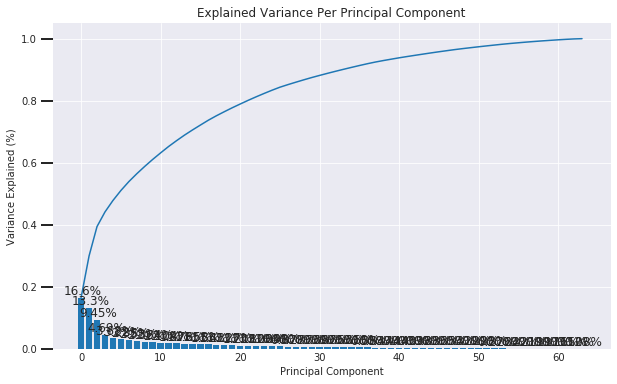

In [79]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

**In order to decide the number of components to choose, we can use the explained variance ratios and the numpy cumulative sum function. I will be taking a number of components that together explain 90% of the data variance.**

In [80]:
# Re-apply PCA to the data while selecting for number of components to retain.
vals = pca.explained_variance_ratio_

In [81]:
n_components = len(np.argwhere(np.cumsum(vals)<=0.9))
print(f"Number of Components that explains 90% of the data variance: {n_components}")

Number of Components that explains 90% of the data variance: 33


In [82]:
#Refitting data
pca = PCA(n_components=n_components)
pca = pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)

### Discussion 2.2: Perform Dimensionality Reduction

PCA was applyed to the scaled data and the explained variance per principal component was analysed through a bar plot.

In order to choose the correct amoiunt of components to use, I decided to select features that, together, explain 90% of the data variance.

As one can see from the results, with this approach I end up selecting 33 components, which reduced the number if features in almost 50%, but maintaining an amazing amount of variance (90%)!

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

The following function was created based on a function provided by Udacity during the course:

In [83]:
def pca_results(full_dataset, pca, num_components):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Component {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 3), columns = full_dataset.keys())
    components.index = dimensions
    components = components.iloc[:num_components]
    
    return components

In [84]:
pca_weights = pca_results(azdias_dist_1,pca,3)
display(pca_weights)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,generation_by_decade,generation_by_movement,wealthy_stage,life_stage,dummy_WOHNLAGE
Component 1,-0.117,0.006,-0.215,0.143,-0.111,0.061,0.074,0.159,0.038,-0.016,...,0.046,-0.167,0.149,0.211,0.142,0.102,0.075,0.202,-0.123,0.155
Component 2,0.261,0.089,0.071,-0.238,0.234,-0.209,-0.228,0.113,-0.059,0.163,...,0.016,-0.067,0.068,0.093,0.066,-0.243,0.001,0.069,0.004,0.074
Component 3,0.080,-0.370,0.158,-0.108,0.102,-0.188,-0.102,-0.044,-0.033,0.108,...,0.003,-0.035,0.032,0.041,0.029,-0.111,-0.027,0.026,-0.008,0.027


In [85]:
print("Visualizing First 2 rows of Weighting Matrix")
display(pca_weights.T.head(2))

Visualizing First 2 rows of Weighting Matrix


,Component 1,Component 2,Component 3
ALTERSKATEGORIE_GROB,-0.117,0.261,0.08
ANREDE_KZ,0.006,0.089,-0.37


***Lets visualize the weights for each feature sorted by weights!***

In [86]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca_weights.T['Component 1'].sort_values(ascending=False)

PLZ8_ANTG3                0.231
PLZ8_ANTG4                0.222
ORTSGR_KLS9               0.211
EWDICHTE                  0.207
wealthy_stage             0.202
HH_EINKOMMEN_SCORE        0.195
FINANZ_HAUSBAUER          0.159
PLZ8_ANTG2                0.159
dummy_WOHNLAGE            0.155
KBA05_ANTG4               0.154
ARBEIT                    0.149
FINANZ_SPARER             0.143
RELAT_AB                  0.142
KBA05_ANTG3               0.136
ANZ_HAUSHALTE_AKTIV       0.136
SEMIO_PFLICHT             0.112
SEMIO_REL                 0.110
generation_by_decade      0.102
SEMIO_RAT                 0.092
SEMIO_TRADV               0.087
SEMIO_FAM                 0.077
SEMIO_MAT                 0.077
generation_by_movement    0.075
FINANZ_UNAUFFAELLIGER     0.074
SEMIO_KULT                0.071
FINANZ_ANLEGER            0.061
REGIOTYP                  0.055
PLZ8_HHZ                  0.046
SEMIO_SOZ                 0.044
SEMIO_KAEM                0.041
                          ...  
SEMIO_DO

In [87]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights.T['Component 2'].sort_values(ascending=False)

ALTERSKATEGORIE_GROB     0.261
FINANZ_VORSORGER         0.234
SEMIO_ERL                0.230
SEMIO_LUST               0.183
RETOURTYP_BK_S           0.163
SEMIO_KRIT               0.115
FINANZ_HAUSBAUER         0.113
SEMIO_KAEM               0.112
W_KEIT_KIND_HH           0.112
EWDICHTE                 0.094
ORTSGR_KLS9              0.093
PLZ8_ANTG3               0.090
ANREDE_KZ                0.089
PLZ8_ANTG4               0.087
dummy_WOHNLAGE           0.074
SEMIO_DOM                0.073
FINANZ_MINIMALIST        0.071
wealthy_stage            0.069
ARBEIT                   0.068
KBA05_ANTG4              0.067
RELAT_AB                 0.066
PLZ8_ANTG2               0.063
WOHNDAUER_2008           0.061
ANZ_HAUSHALTE_AKTIV      0.060
HH_EINKOMMEN_SCORE       0.050
KBA05_ANTG3              0.044
VERS_TYP                 0.036
ANZ_HH_TITEL             0.030
PLZ8_HHZ                 0.016
REGIOTYP                 0.008
                         ...  
SOHO_KZ                 -0.002
KKK     

In [88]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights.T['Component 3'].sort_values(ascending=False)

SEMIO_VERT                0.347
SEMIO_SOZ                 0.262
SEMIO_FAM                 0.250
SEMIO_KULT                0.236
FINANZ_MINIMALIST         0.158
RETOURTYP_BK_S            0.108
FINANZ_VORSORGER          0.102
W_KEIT_KIND_HH            0.084
ALTERSKATEGORIE_GROB      0.080
SEMIO_REL                 0.068
SEMIO_LUST                0.064
SEMIO_MAT                 0.055
PLZ8_ANTG4                0.041
ORTSGR_KLS9               0.041
EWDICHTE                  0.040
PLZ8_ANTG3                0.040
WOHNDAUER_2008            0.033
ARBEIT                    0.032
RELAT_AB                  0.029
dummy_WOHNLAGE            0.027
PLZ8_ANTG2                0.026
wealthy_stage             0.026
KBA05_ANTG4               0.025
ANZ_HAUSHALTE_AKTIV       0.023
VERS_TYP                  0.021
ANZ_HH_TITEL              0.012
KBA05_ANTG3               0.009
ANZ_TITEL                 0.009
PLZ8_HHZ                  0.003
SOHO_KZ                   0.000
                          ...  
KKK     

### Discussion 2.3: Interpret Principal Components

In order to understand the meaning of the principal componentes, I selected the top 3 variance components (which together represent almost 40% of variance, as shown in the previous graph).

Mapping each weight to its corresponding features, we can clearly point out the following features as interesting, i.e, features that are probably really usefull in modeling the data:

Component 1:
- PLZ8_ANTG3
- wealthy_stage
- EWDICHTE
- ORTSGR_KLS9
- FINANZ_SPARER

- PLZ8_GBZ       
- KONSUMNAEHE         
- KBA05_GBZ           
- KBA05_ANTG1            

Component 2:
- ALTERSKATEGORIE_GROB
- FINANZ_VORSORGER
- SEMIO_ERL

- SEMIO_TRADV2
- FINANZ_ANLEGER
- SEMIO_PFLICHT
- FINANZ_UNAUFFAELLIGER
- FINANZ_SPARER
- SEMIO_REL

Component 3:
- SEMIO_VERT
- SEMIO_SOZ
- SEMIO_KULT
- SEMIO_FAM 

- SEMIO_KRIT
- SEMIO_DOM 
- ANREDE_KZ 
- SEMIO_KAEM

From the above, we can point out some feature "families":

1) SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST, SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,SEMIO_PFLICHT, SEMIO_TRADV : **Personality typology**

2) FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER: **Financial typology**

3) ALTERSKATEGORIE_GROB: **Estimated age**

4) PLZ8's: **Number of family houses in the PLZ8 region**

Therefore, those are groups of feature that I will be looking for when recomending customer segments!

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

The following function was adapted from a function given by Udacity:

The following function was created based on a function provided by Udacity during the course:

In [91]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    #Obtain Silhouette Score
    #silh_score = silhouette_score(data, model.labels_, metric='euclidean', sample_size = 10000)
    
    return score

In [95]:
# Over a number of different cluster counts...

# run k-means clustering on the data and...    
# compute the average within-cluster distances.

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
silh_scores = []
centers = list(range(2,15))

for center in centers:
    score = get_kmeans_score(X_pca, center)
    scores.append(score)
    #silh_scores.append(silh_score)

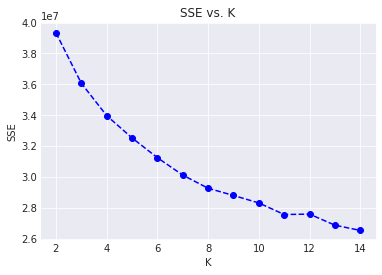

In [96]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
plt.show()

In [97]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=9)
clf = kmeans.fit(X_pca)

In [98]:
pred = clf.predict(X_pca)

In [99]:
print(pred)

[0 6 8 ..., 5 2 7]


In [100]:
print(pred.shape)

(797906,)


#### Saving and Loading the model can be done bellow

In [101]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [102]:
#from sklearn.externals import joblib
#filename = 'finalized_model.sav'
#clf = joblib.load(filename)
#pred = loaded_model.predict(X_pca)
#print(result)

### Discussion 3.1: Apply Clustering to General Population

In this discussion I will be explaining the clustering process and how I end up chosing the number k of clusters to be used.

First of all, the cleaned, scaled and reduced data was trained within a range of 14 different k values using the K-means algorithm. For each value of K, the resulting mean distance to the centroid was computed and plotted in the displayed graph.

What is interest to observe from the graph is the following:
    
   - Since the resulting number of principle components was 32, if we consider taking 10 clusters or more, we would be using more than 30% of the number of features as clusters, which is kind of overfitting the data. This can be also be seen from the fact that beyond 9 clusters the SSE is bellow 3.
   
   
   - We can se a "elbow" behavior when the number of clusters reach 11: from 10 to eleven a sutil increase in the SSE happens, which means we probably reached a local point to be considered.
    
Therefore, I decided to choose 9 as the number of clusters for the analyses.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [108]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
print(customers.shape)

(191652, 85)


In [109]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

def process_data(df,imp,scaler,pca):
    """
    This function process the customer data applying the scaler
    and the PCA transformation fitted during training (general data)
    
    Arguments:
        df: cleaned customer dataframe
        imp: the data imputer
        scaler: the trained scaler object
        pca: the trained pca object
    """
    
    #Data imputation for NaN values
    imp_data = imp.transform(df)

    #Scale Data
    scaled_data = scaler.transform(imp_data)
    
    #Perform PCA
    X_pca = pca.transform(scaled_data)
    
    return X_pca

In [110]:
cust_clean = clean_data(customers,feat_info)
print(cust_clean)

/opt/conda/lib/python3.6/site-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


        ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        4.0          0                5.0            1.0   
1                        4.0          0                5.0            1.0   
2                        4.0          1                5.0            1.0   
3                        4.0          0                5.0            1.0   
4                        3.0          0                3.0            1.0   
5                        3.0          0                5.0            1.0   
6                        4.0          0                5.0            1.0   
7                        4.0          0                5.0            1.0   
8                        4.0          1                2.0            2.0   
9                        3.0          0                5.0            2.0   
10                       3.0          1                4.0            2.0   
11                       4.0          0                5.0            1.0   

In [111]:
#Drop features that are not in the training set
cust_columns = cust_clean.columns
base_columns = azdias_dist_1.columns

In [113]:
X_cust_pca = process_data(cust_clean,imp,scaler,pca)

In [114]:
X_cust_pca

array([[-5.78651632,  0.80768308,  4.1604313 , ..., -0.66966146,
         0.72325556, -0.01055598],
       [-0.94468143,  1.23542621,  3.48805399, ..., -0.95461545,
        -0.21575095,  0.80533969],
       [-1.21154309,  4.98796677, -0.76786799, ...,  0.65264017,
         0.34492919,  0.31449291],
       ..., 
       [-4.00125687,  2.84304652,  2.37007802, ...,  1.22994224,
        -0.28772787, -0.33296367],
       [-1.04026168,  2.78141096, -1.93776579, ...,  1.28792975,
         0.10887483, -0.31893066],
       [-4.01399246, -2.84811022,  2.38581379, ...,  1.27409943,
        -0.77320045, -0.48226626]])

In [115]:
#PRedictions
pred_cust = clf.predict(X_cust_pca)

In [116]:
pred_cust

array([1, 7, 6, ..., 1, 6, 1], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

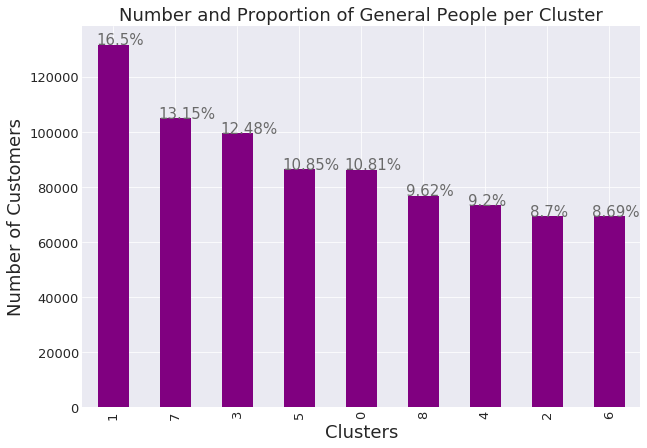

In [117]:
#Reference for plot procedure: https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
df_base = pd.DataFrame(pred).rename(columns={0:"num_people"})
ax = df_base['num_people'].value_counts().plot(kind='bar', figsize=(10,7), color="purple", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Number and Proportion of General People per Cluster", fontsize=18)
ax.set_xlabel("Clusters", fontsize=18);
ax.set_ylabel("Number of Customers", fontsize=18);

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')

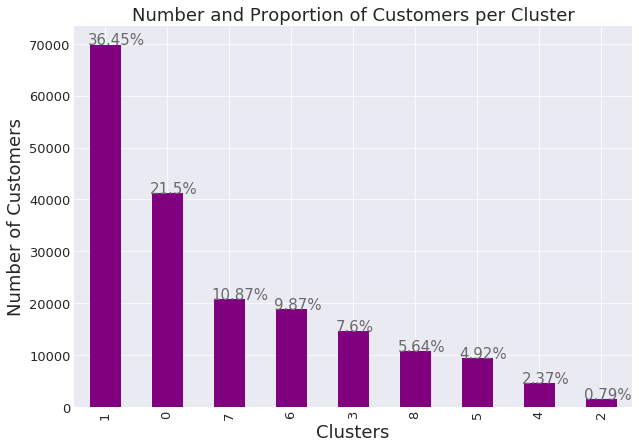

In [118]:
#Reference for plot procedure: https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

df_cust = pd.DataFrame(pred_cust).rename(columns={0:"num_people"})
ax = df_cust['num_people'].value_counts().plot(kind='bar', figsize=(10,7), color="purple", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Number and Proportion of Customers per Cluster", fontsize=18)
ax.set_xlabel("Clusters", fontsize=18);
ax.set_ylabel("Number of Customers", fontsize=18);

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')

In [119]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

In [125]:
customers_cluster_1 = np.argwhere(pred_cust==1)

In [126]:
X_pca_values_cust_clust_1 = X_cust_pca[customers_cluster_1]

In [127]:
X_values_cust_clust_1 = pca.inverse_transform(X_pca_values_cust_clust_1)

In [128]:
#X_cust_clust_1 = scaler.inverse_transform(X_values_cust_clust_1)

In [129]:
np.squeeze(X_values_cust_clust_1)

array([[  1.45505487e+00,  -1.24083042e+00,   1.50630597e+00, ...,
         -1.56576676e+00,   6.35729948e-02,  -2.01206000e+00],
       [  6.79720582e-01,  -9.11824730e-01,   1.62665757e+00, ...,
         -7.78030183e-01,   7.34627417e-01,  -1.46623022e+00],
       [  2.59168059e-01,  -8.54376240e-01,   1.38450144e+00, ...,
         -7.39317182e-01,   7.17528468e-01,   9.46157029e-01],
       ..., 
       [  2.55236250e-01,  -9.39154986e-01,   1.58831450e+00, ...,
         -1.46775256e+00,   7.95163441e-01,   5.24237167e-01],
       [  1.57840428e+00,  -6.66709103e-01,   1.51220367e+00, ...,
         -6.65258682e-01,   8.31974452e-01,   1.19904655e+00],
       [ -7.45484648e-01,  -7.90223713e-01,   1.34209963e+00, ...,
         -1.11405336e-03,   9.98206771e-02,  -1.70714129e+00]])

In [130]:
cluster_1 = pd.DataFrame(data=np.squeeze(X_values_cust_clust_1),columns=cust_clean.columns)

In [131]:
cluster_1.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,generation_by_decade,generation_by_movement,wealthy_stage,life_stage,dummy_WOHNLAGE
0,1.455055,-1.240830,1.506306,-1.254969,1.158420,-1.440202,-0.505979,-0.452158,-1.493788,1.120078,...,1.156059,1.609595,-1.930996,-1.357790,-1.728617,-1.127988,-1.750858,-1.565767,0.063573,-2.012060
1,0.679721,-0.911825,1.626658,-1.445634,1.163499,-1.023296,-1.032377,-0.707503,-0.483135,-0.311212,...,-0.387775,0.444497,-1.921102,-1.664788,-1.665192,-1.454186,0.931930,-0.778030,0.734627,-1.466230
2,0.259168,-0.854376,1.384501,-1.276757,1.444140,-1.456377,-0.759935,-0.326774,1.016331,-0.448268,...,1.863905,1.223606,0.351006,0.111813,1.122644,-1.032611,-1.906059,-0.739317,0.717528,0.946157
3,0.522035,-0.729485,1.771277,-1.400561,1.510080,-0.998105,-1.049993,-0.651876,-0.651613,1.061309,...,1.431094,1.750060,-1.070456,-1.332602,-0.783527,-1.126895,-1.458743,-1.146542,-0.011346,-1.769126
4,1.341044,-1.265529,1.528590,-1.299566,1.037117,-1.653419,-0.447257,-0.408315,-1.401980,0.975020,...,-0.559676,-0.126919,-0.522575,-0.265920,-0.027931,-1.178076,-1.959430,-1.616889,1.446508,0.244218
5,0.065103,-0.994157,1.536635,-0.562038,0.532193,-0.907345,0.069345,-1.675707,0.910031,-0.918050,...,1.232412,1.546336,0.254600,0.653190,0.344139,-0.088001,-1.592742,-1.730579,1.383429,0.621348
6,0.603670,-1.120634,1.566880,-1.218781,0.923091,-1.535280,-0.358940,-0.473222,-1.758081,0.852104,...,-0.694088,0.353435,-1.558334,-0.522600,-1.429608,-0.939724,-1.882987,-1.542879,0.808836,0.525422
7,0.832835,-1.017386,1.211325,-0.515150,0.491327,-0.054843,-0.264393,-1.123467,-0.268191,-0.268465,...,0.607449,1.389852,-1.933851,-1.813548,-1.757455,-0.419465,0.580925,-0.679128,-0.642335,-1.821540
8,0.335036,-0.973090,1.232830,-0.263136,0.266640,-0.577657,0.120897,-1.977203,0.864284,-0.361646,...,0.081784,0.740205,0.932807,-0.030575,1.457485,0.180653,0.510468,0.195394,0.102450,0.425475
9,0.265470,-0.914328,1.516011,-1.297149,1.085152,-1.605604,-0.823369,-0.465518,-1.677650,-0.213781,...,1.844201,2.074759,-0.727580,0.212907,-1.223874,-0.939299,-1.956619,-1.535289,1.474016,0.351136


In [132]:
cluster_1.mean()

ALTERSKATEGORIE_GROB      0.709405
ANREDE_KZ                -0.949870
FINANZ_MINIMALIST         1.404756
FINANZ_SPARER            -1.067376
FINANZ_VORSORGER          0.996339
FINANZ_ANLEGER           -1.061309
FINANZ_UNAUFFAELLIGER    -0.661521
FINANZ_HAUSBAUER         -0.675989
HEALTH_TYP               -0.390865
RETOURTYP_BK_S            0.394496
SEMIO_SOZ                 0.313740
SEMIO_FAM                 0.304240
SEMIO_REL                -0.261156
SEMIO_MAT                -0.072633
SEMIO_VERT                1.039863
SEMIO_LUST                0.579735
SEMIO_ERL                -0.160865
SEMIO_KULT                0.310607
SEMIO_RAT                -0.857001
SEMIO_KRIT               -0.898423
SEMIO_DOM                -0.820018
SEMIO_KAEM               -0.957087
SEMIO_PFLICHT            -0.692464
SEMIO_TRADV              -0.481277
SOHO_KZ                   0.012611
VERS_TYP                 -0.090980
ANZ_PERSONEN              0.708255
ANZ_TITEL                 0.265559
HH_EINKOMMEN_SCORE  

In [133]:
cluster_1.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,generation_by_decade,generation_by_movement,wealthy_stage,life_stage,dummy_WOHNLAGE
count,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,...,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000,69856.000000
mean,0.709405,-0.949870,1.404756,-1.067376,0.996339,-1.061309,-0.661521,-0.675989,-0.390865,0.394496,...,0.004723,0.489121,-0.530327,-0.353846,-0.385031,-0.883184,-0.816583,-0.861978,0.465893,-0.129928
std,0.527034,0.230465,0.340753,0.408359,0.492582,0.517741,0.434163,0.570442,1.067198,0.718268,...,0.980485,0.746734,0.918123,0.812347,0.972093,0.494935,1.095893,0.607840,0.764484,1.016059
min,-1.635944,-1.923732,-0.866794,-1.788886,-1.781236,-2.356998,-2.054860,-2.433430,-2.129112,-1.951329,...,-3.272915,-2.188861,-2.403643,-2.151719,-2.612122,-1.945365,-2.497138,-2.466971,-1.891428,-2.395593
25%,0.253494,-1.110933,1.281271,-1.336759,0.841909,-1.425244,-0.951467,-0.975794,-1.487589,-0.245227,...,-0.671810,-0.100605,-1.212533,-1.117051,-1.233843,-1.217584,-1.732461,-1.310578,-0.018362,-1.418229
50%,0.778517,-0.949891,1.479904,-1.199457,1.139926,-1.116180,-0.729400,-0.673828,-0.433802,0.566716,...,-0.205830,0.429885,-0.592601,-0.245072,-0.435927,-1.029702,-1.461070,-0.938195,0.697933,0.388342
75%,1.119248,-0.791580,1.628052,-0.970128,1.318488,-0.775016,-0.442567,-0.410489,0.836815,1.013199,...,0.612581,1.096177,0.228224,0.254742,0.338789,-0.723247,0.450990,-0.490138,0.955533,0.612446
max,2.071970,0.946347,2.241931,1.349187,2.236256,1.754157,2.067824,1.892962,1.581133,1.935695,...,2.846947,2.661476,2.312679,1.486573,2.103740,1.549071,1.424522,1.696617,1.884012,1.585865


In [116]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [134]:
customers_cluster_2 = np.argwhere(pred_cust==2)

In [135]:
X_pca_values_cust_clust_2 = X_cust_pca[customers_cluster_2]

In [136]:
X_values_cust_clust_2 = pca.inverse_transform(X_pca_values_cust_clust_2)

In [137]:
#X_cust_clust_2 = scaler.inverse_transform(X_values_cust_clust_2)

In [138]:
np.squeeze(X_values_cust_clust_2)

array([[-1.0905146 , -0.9377831 , -0.39674933, ...,  0.85797361,
        -1.11662325,  0.40113625],
       [-0.81607016, -1.19315526,  0.38435487, ...,  0.33359117,
         1.21374469,  0.80524577],
       [-1.25157318, -1.33394338, -0.83210847, ...,  0.65844558,
        -1.21737285,  0.56278916],
       ..., 
       [ 0.37506999, -1.29537309, -0.80002772, ...,  0.85989172,
        -1.12608912,  0.46930129],
       [-1.51871896, -1.29078957, -0.63227161, ...,  0.52212732,
        -1.04364101,  0.05319964],
       [-0.80346931, -1.45410369,  0.2885725 , ..., -0.44889456,
         0.96353806,  0.67209739]])

In [139]:
cluster_2 = pd.DataFrame(data=np.squeeze(X_values_cust_clust_2),columns=cust_clean.columns)

In [140]:
cluster_2.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,generation_by_decade,generation_by_movement,wealthy_stage,life_stage,dummy_WOHNLAGE
0,-1.090515,-0.937783,-0.396749,0.812870,-0.701261,-0.220686,0.814241,-0.193178,-1.586814,-0.532817,...,-0.539876,-1.974128,0.239441,1.220417,0.927027,0.754315,0.569274,0.857974,-1.116623,0.401136
1,-0.816070,-1.193155,0.384355,-0.106856,0.066226,-1.024753,-0.107910,-0.408485,-0.304790,-0.346058,...,-0.573081,-0.141667,0.769970,1.004067,0.823969,0.119524,-1.450956,0.333591,1.213745,0.805246
2,-1.251573,-1.333943,-0.832108,1.349282,-1.670692,0.724970,0.183552,0.210552,0.733203,-0.350515,...,0.907254,-0.919666,0.916240,1.449752,-0.008245,1.198920,0.918039,0.658446,-1.217373,0.562789
3,-0.871553,-1.491603,0.212395,-0.129869,-0.272897,-0.346672,-1.252258,0.055249,0.821706,0.965780,...,-0.735308,-2.050864,0.055470,0.558109,-0.685374,0.051634,0.806927,0.339697,0.326512,0.768103
4,-1.359148,-1.303305,0.608537,-0.199245,-0.311107,-0.630919,-0.554771,-0.381015,-1.656209,0.824316,...,0.132201,-0.318311,1.004176,1.009151,0.031456,-0.078239,0.446746,0.348404,1.445160,0.859719
5,-1.201669,-1.193999,-0.671907,1.215082,-0.897932,0.688573,1.449078,0.130010,-0.530390,0.214636,...,-0.486518,-0.907629,0.291197,-0.036073,1.324322,1.192662,-1.601504,0.473894,0.488036,0.721214
6,-0.746942,-1.548138,-0.888454,1.034464,-0.606709,-0.038425,1.068456,0.410559,-1.648309,0.917161,...,1.063156,-0.559585,0.253230,0.777387,1.289460,1.079936,-1.515792,0.469960,0.869211,0.621445
7,0.419955,-1.159723,-0.557630,1.254735,-1.266870,0.533456,1.314362,-0.752290,0.974191,0.444642,...,1.198654,0.490978,0.070916,0.583214,0.669406,1.292963,0.703502,-0.036762,-0.064739,0.921556
8,-0.424725,-1.252872,0.390665,-0.039938,0.054837,-0.941015,-0.013019,-0.497685,1.022853,0.979359,...,-0.443998,-0.481939,1.410476,1.085038,1.709559,-0.168809,0.498973,0.736483,-1.089893,0.801077
9,-0.030378,-1.049905,-0.368522,0.779174,-1.082795,-0.546522,1.195794,-0.576997,0.939248,0.478419,...,1.069067,-0.067129,0.322371,0.612832,1.236766,0.650942,0.554123,-0.345383,0.440272,0.715083


In [141]:
cluster_2.mean()

ALTERSKATEGORIE_GROB     -0.724378
ANREDE_KZ                -1.127044
FINANZ_MINIMALIST        -0.351766
FINANZ_SPARER             0.700078
FINANZ_VORSORGER         -0.646833
FINANZ_ANLEGER            0.024203
FINANZ_UNAUFFAELLIGER     0.504251
FINANZ_HAUSBAUER         -0.035294
HEALTH_TYP                0.161067
RETOURTYP_BK_S           -0.084464
SEMIO_SOZ                 1.174908
SEMIO_FAM                 1.233528
SEMIO_REL                 1.010822
SEMIO_MAT                 0.541653
SEMIO_VERT                0.951351
SEMIO_LUST               -0.471711
SEMIO_ERL                -1.199168
SEMIO_KULT                1.262058
SEMIO_RAT                 0.024102
SEMIO_KRIT               -0.967756
SEMIO_DOM                -0.844714
SEMIO_KAEM               -0.902391
SEMIO_PFLICHT             0.623404
SEMIO_TRADV               0.490825
SOHO_KZ                  -0.048514
VERS_TYP                  0.004161
ANZ_PERSONEN              0.034270
ANZ_TITEL                 0.073129
HH_EINKOMMEN_SCORE  

In [142]:
cluster_2.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,generation_by_decade,generation_by_movement,wealthy_stage,life_stage,dummy_WOHNLAGE
count,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,...,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000
mean,-0.724378,-1.127044,-0.351766,0.700078,-0.646833,0.024203,0.504251,-0.035294,0.161067,-0.084464,...,0.166856,-0.714768,0.430667,0.885174,0.485318,0.647019,-0.040349,0.550735,-0.476147,0.539379
std,0.639286,0.284839,0.676314,0.644807,0.666095,0.665353,0.786774,0.724878,0.949811,0.877234,...,0.761823,0.799203,0.582898,0.517147,0.670637,0.592636,0.966091,0.585929,1.016585,0.294268
min,-1.850173,-1.848392,-1.923386,-1.121625,-2.010587,-1.729838,-1.852715,-2.240970,-1.960508,-2.094801,...,-2.562220,-2.926380,-2.036246,-1.569693,-1.964942,-1.360897,-2.386827,-1.485734,-1.652561,-1.966271
25%,-1.233763,-1.333811,-0.791378,0.089099,-1.100175,-0.469321,-0.104795,-0.513210,-0.456704,-0.485177,...,-0.441493,-1.261911,0.167473,0.560252,-0.030211,0.151152,-1.280046,0.203808,-1.278193,0.428687
50%,-0.857628,-1.151197,-0.403275,0.967123,-0.789215,0.068766,0.686895,-0.090490,0.690055,-0.000342,...,0.231788,-0.669153,0.476534,1.009861,0.490679,0.883644,0.471853,0.619541,-1.117959,0.561909
75%,-0.211143,-0.972444,0.142246,1.205511,-0.170440,0.517961,1.141669,0.431478,1.001725,0.606174,...,0.745337,-0.210810,0.867572,1.311077,1.040375,1.095130,0.643556,0.948262,0.590387,0.693386
max,1.328961,0.022305,1.617552,1.817647,1.683075,1.509234,2.358471,1.927320,1.425551,1.611692,...,2.467507,1.722758,2.152949,1.747625,1.950324,1.877687,1.284760,4.965132,1.760930,1.260907


In [143]:
print(cluster_1['PLZ8_ANTG3'].mean())
print(cluster_2['PLZ8_ANTG3'].mean())
print("\n")
print(cluster_1['wealthy_stage'].mean())
print(cluster_2['wealthy_stage'].mean())
print("\n")
print(cluster_1['FINANZ_VORSORGER'].mean())
print(cluster_2['FINANZ_VORSORGER'].mean())
print("\n")
print(cluster_1['FINANZ_UNAUFFAELLIGER'].mean())
print(cluster_2['FINANZ_UNAUFFAELLIGER'].mean())
print("\n")
print(cluster_1['FINANZ_SPARER'].mean())
print(cluster_2['FINANZ_SPARER'].mean())
print("\n")
print(cluster_1['SEMIO_REL'].mean())
print(cluster_2['SEMIO_REL'].mean())

-0.549683028589
0.915674030762


-0.861978440487
0.550735207878


0.996338972053
-0.646832967552


-0.66152099548
0.504250801329


-1.06737615673
0.70007824743


-0.261155731758
1.0108217243


**Notice that only the inverse PCA was performed, such that we can analyse the magnitude of the scaled coefficients. Since StandardScaler was used, strongly negative values suggest lower values on the original scale and positive values suggest higher values on the original scale.** 

We can plot the top 10 positive and top 10 negative scaled features for each cluster, as shown bellow.

The function bellow was provided by Udacity's revewer:

In [177]:
def plot_scaled_comparison(df_sample, kmeans, cluster):
    """
    Plot top 10 positive and top 10 negative scaled features for the given cluster.
    Arguments:
        df_sample: sample dataframe
        kmeans: the fitted k-means classifier
        cluster: the cluster to be analysed
    """
    
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
                                        pca.inverse_transform(kmeans.cluster_centers_[cluster]))),
                                        orient='index').rename(columns={0: 'feature_values'}).\
                                        sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    plt.figure(figsize=(10,7))
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

**Plot for Cluster 1**

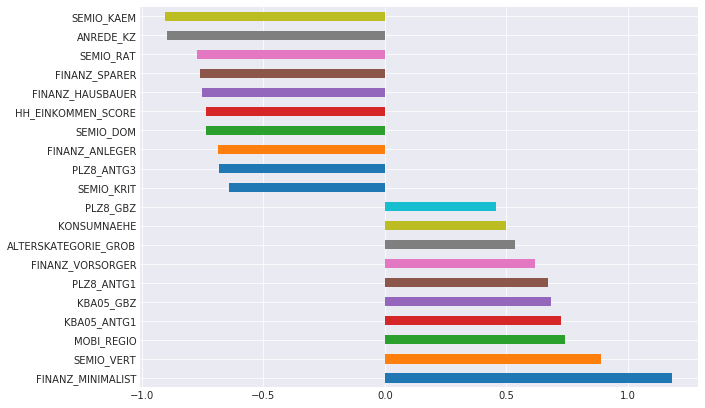

In [178]:
plot_scaled_comparison(customers,clf,1)

**Plot for Cluster 2**

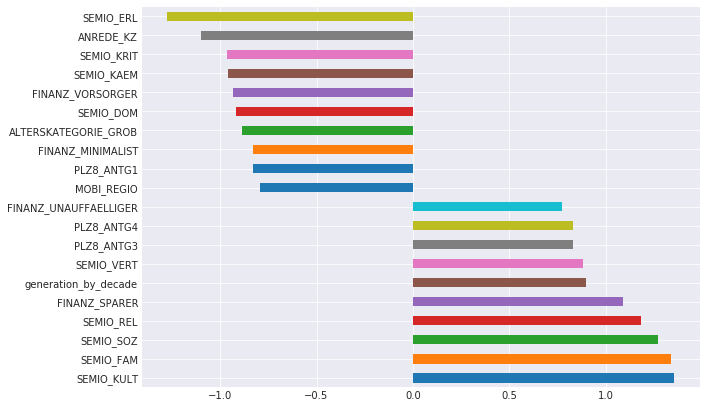

In [179]:
plot_scaled_comparison(customers,clf,2)

### Discussion 3.3: Compare Customer Data to Demographics Data

Now it is time to figure out what is going on!!

**First of all, what is our goal? Our goal is to find segments that can be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns.**

From the clustering analyses, we can imediatly conclude the following characteristics:

   - Cluster 1 and 0 aggregates almost 60% of the company customers. However, that is not true at all for the general population. This discrepancy highly suggests that clusters 1 and 0 are good segments to consider as targets for campaigns.
   
   
   - In the opposite direction, one can notice that clusters 7, 3, 8, 5, 4 and 2 almost do not include customers. However, those clusters contain a significant percentage of people in the general population. Therefore, those clusters are also interest in the sence that they indicate segments that should be kept outside of the mailing desired audience.
   
I decided to took clusters 1 and 2 in order to understand what are the expected characteristics of someone in each segment. **But what characteristics can we analyzed in this huge universe of features? Well, we could look at the principal components results, as well as to the two figures above that display relevant features for the analysis**.

From the PCA analyzes, a list of interest attributes was obtained. Verifying the average scaled values for these features (printed above) and also visualizing both figures above, we can create a profile that can be usefull for the marketing compaigns. Some of the profile characteristics for target group includes:

   - high FINANZ_HAUSBAUER and FINANZ_SPARER financial typology
   - low FINANZ_MINIMALIST typology
   - high affinity with SEMIO_KAEM and SEMIO_RAT personality typology
   - lower movement patterns (MOBI_REGIO)
   - higher share of 1-2 family homes 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.